<ipython-input-7-fc6b6eacfd33>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.float)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


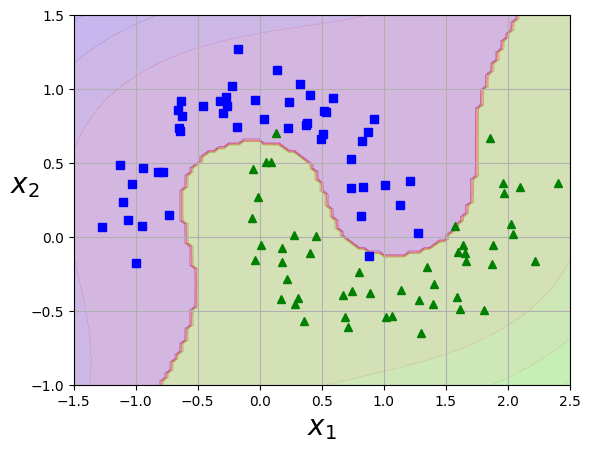

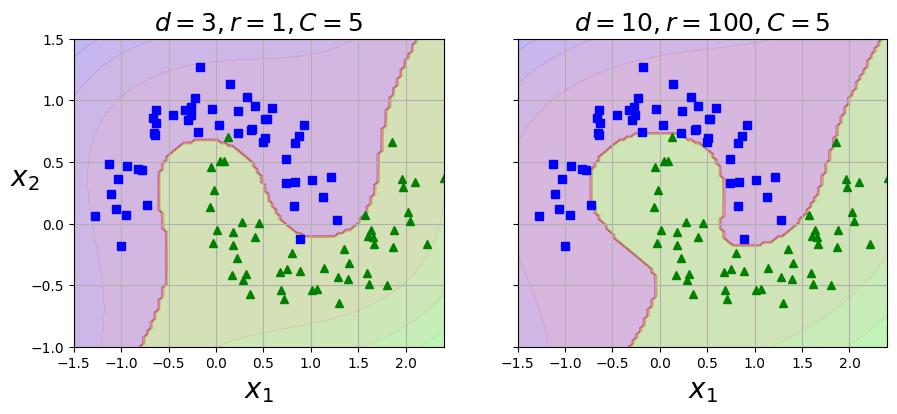

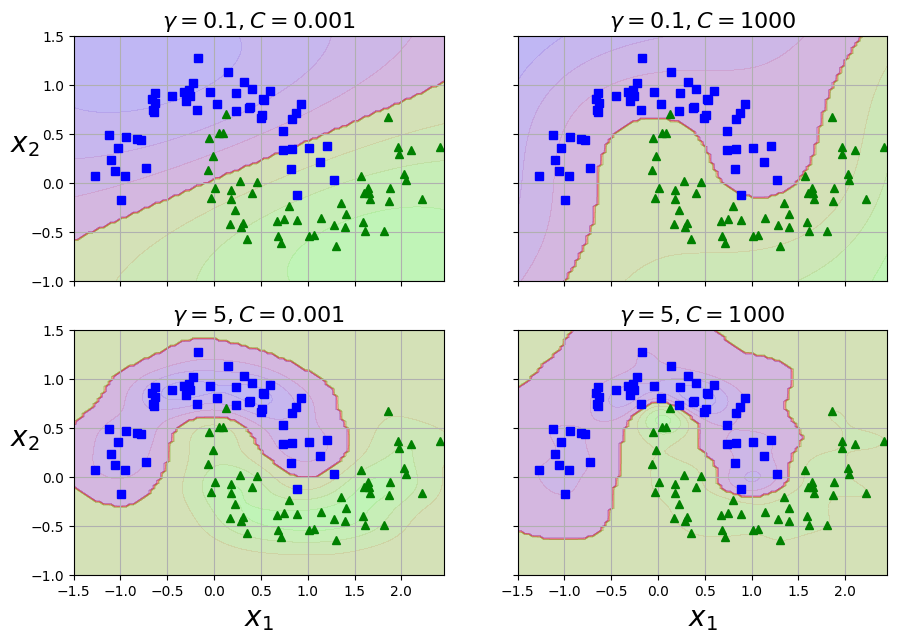

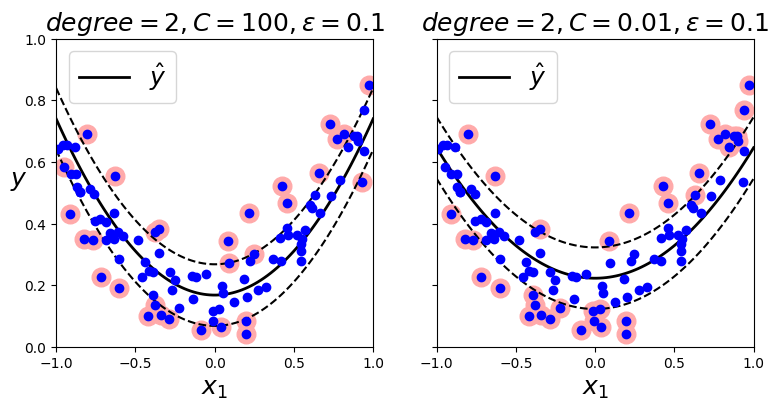

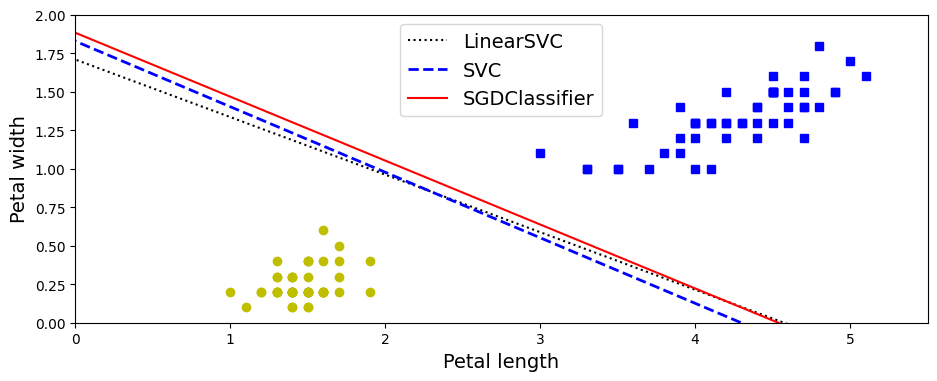

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.float)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C = 1, loss = "hinge"))
])
svm_clf.fit(X, y)

from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15, random_state = 42)

# 산점도 그리기 함수
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")   # 파랑 네모: 음성 데이터
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")   # 초록 세모: 양성 데이터
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)


#등고선 그리기 함수
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)       # 결정경계 그리기
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)   # 등고선 그리기

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

#다항식 커널 이용
from sklearn.svm import SVC

#3차항 커널
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 5))
])
poly_kernel_svm_clf.fit(X, y)
#10차항 커널
poly10_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly10_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# 왼편 그림 (3차항)
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

# 오른편 그림 (10차항)
plt.sca(axes[1])
plot_predictions(poly10_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")


plt.show()

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)
svm_clfs = []
for gamma, C in hyperparams:
  rbf_kernel_svm_clf = Pipeline([
      ("scaler", StandardScaler()),
      ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
  ])
  rbf_kernel_svm_clf.fit(X, y)
  svm_clfs.append(rbf_kernel_svm_clf)

# 그림 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

def plot_svm_regression(svm_reg, X, y, axes):
    # 결정경계 선과 도로 경계 그리기
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")   # 결정경계 선 (검은 실선)
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")                 # 위쪽 도로 경계 (검은 파선)
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")                 # 아랫쪽 도로 경계 (검은 파선)

    # X 데이터셋의 샘플 중에서 마진 오류 샘플 표시하기 (분홍 원)
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')

    # X, y 데이터셋 표기 (파랑 점)
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

#규제 강도만 다르게 설정하여 실행
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

fig, axes = plt.subplots(ncols = 2, figsize = (9,4), sharey = True)

plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

#연습문제 8번

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]       #꽃잎 길이, 너비를 사용
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)

X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C* len(X))

lin_clf = LinearSVC(loss = "hinge", C=C, random_state = 42)
svm_clf = SVC(kernel = "linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate = "constant", eta0 = 0.001, alpha = alpha,
                        max_iter = 1000, tol = 1e-3, random_state =42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]


# 결정경계를 원본 축척으로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()


from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', vertsion=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

#이미 섞여있는데 데이터셋이므로 train_test_split() 대신 배열 슬라이싱
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

lin_clf = LinearSVC(random_state=42)
lin_clf.fit (X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))


svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

from sklearn.model_selection import RandomizeSearchCV
from scipy.stats import reciprocal, uniform
#적절한 하이퍼파라미터 gamma와 C를 찾기위해 균일분포 후 랜덤 서치
param_distributions = {"gamma": reciprocal(0.001, 0.1) "C":uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv,fit(X_train_scaled[:1000], y_train[:1000])
